In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input
from darts.models import FFT
from darts import TimeSeries

# Crude Oil WTI

## 7:3

In [50]:
# Đọc dữ liệu
df = pd.read_csv('../dataset/Crude Oil WTI.csv')

In [51]:
# Tiền xử lý dữ liệu
# Chuyển đổi cột 'Date' thành kiểu dữ liệu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [52]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-05-31,76.99,77.91,78.62,76.67,345.12K,-1.18%
1,2024-05-30,77.91,79.28,79.42,77.63,373.78K,-1.67%
2,2024-05-29,79.23,80.26,80.62,78.99,259.59K,-0.75%
3,2024-05-28,79.83,77.81,80.29,77.69,334.07K,1.50%
4,2024-05-27,78.65,77.84,78.80,77.75,NaN,1.20%
...,...,...,...,...,...,...,...
1381,2019-03-07,56.66,56.20,56.99,56.08,628.82K,0.78%
1382,2019-03-06,56.22,56.28,56.40,55.42,637.68K,-0.60%
1383,2019-03-05,56.56,56.45,57.19,56.09,538.40K,-0.05%
1384,2019-03-04,56.59,55.83,57.00,55.81,549.40K,1.42%


In [53]:

# Chuyển đổi cột 'Vol.' thành số
# Chuyển đổi cột 'Change %' thành số
def convert_volume_to_number(volume_str):
    if isinstance(volume_str, float):
        return volume_str
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    else:
        return volume_str


def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%'))
    return new_change

def convert_str_to_number(str):
    return float(str.replace(',', ''))

df['Vol.'] = df['Vol.'] .apply(convert_volume_to_number)
df['Change %'] = df['Change %'].apply(convert_change_to_number)

# Đảo ngược dữ liệu để dự đoán giá trị trong tương lai
df = df.iloc[::-1].reset_index(drop=True)

In [54]:
# Chuyển đổi cột 'Price' thành mảng NumPy
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2019-03-01,55.80,57.22,57.88,55.57,684190.0,-2.48
1,2019-03-04,56.59,55.83,57.00,55.81,549400.0,1.42
2,2019-03-05,56.56,56.45,57.19,56.09,538400.0,-0.05
3,2019-03-06,56.22,56.28,56.40,55.42,637680.0,-0.60
4,2019-03-07,56.66,56.20,56.99,56.08,628820.0,0.78
...,...,...,...,...,...,...,...
1296,2024-05-24,77.72,77.04,78.05,76.15,299080.0,1.11
1297,2024-05-28,79.83,77.81,80.29,77.69,334070.0,1.50
1298,2024-05-29,79.23,80.26,80.62,78.99,259589.0,-0.75
1299,2024-05-30,77.91,79.28,79.42,77.63,373780.0,-1.67


In [55]:
# Tạo dữ liệu giả cho các ngày cuối tuần thiếu
def fill_missing_weekends(df):
    weekend_data = pd.DataFrame(columns=df.columns)
    all_dates = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
    for date in all_dates:
        # Kiểm tra xem ngày đó có trong dữ liệu không
        if date not in df['Date'].values:
            # Nếu không có, tìm ngày trước và sau đó trong dữ liệu
            previous_day = df[df['Date'] < date]
            next_day = df[df['Date'] > date]
            # Kiểm tra DataFrame có dữ liệu không
            if not previous_day.empty and not next_day.empty:
                previous_day = previous_day.iloc[-1]
                next_day = next_day.iloc[0]
                # Tính toán giá trị trung bình của các cột (trừ cột 'Date')
                new_row_values = (previous_day.drop('Date') + next_day.drop('Date')) / 2
                # Tạo một Series mới với ngày và giá trị mới
                new_row = pd.Series([date] + new_row_values.tolist(), index=df.columns)
                # Thêm dòng dữ liệu vào DataFrame mới
                weekend_data.loc[len(weekend_data)] = new_row

    # Kết hợp dữ liệu gốc và dữ liệu cuối tuần giả mạo
    df = pd.concat([df, weekend_data], ignore_index=True)
    df.sort_values(by='Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# Áp dụng hàm để điền giá trị cho các ngày cuối tuần
df = fill_missing_weekends(df)

In [56]:
price = df['Price'].values
price = price.reshape(-1, 1)

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [58]:
train_size = int(len(price_scaled) * 0.7)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [59]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [60]:
forecast = model.predict(len(series_test))

In [61]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.20058979242452077
MAE: 0.18051124219259046
MAPE: 24.980444250965952%


In [62]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 666, component: 1, sample: 1)> Size: 5kB
array([[[0.66763827]],

       [[0.66649615]],

       [[0.66537213]],

       [[0.66426597]],

       [[0.66317742]],

       [[0.66210623]],

       [[0.66105215]],

       [[0.66001491]],

       [[0.65899424]],

       [[0.65798986]],

...

       [[0.5200275 ]],

       [[0.5212939 ]],

       [[0.52257429]],

       [[0.52386829]],

       [[0.52517551]],

       [[0.52649554]],

       [[0.52782798]],

       [[0.52917239]],

       [[0.53052836]],

       [[0.53189545]]])
Coordinates:
  * time       (time) int64 5kB 1343 1344 1345 1346 1347 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


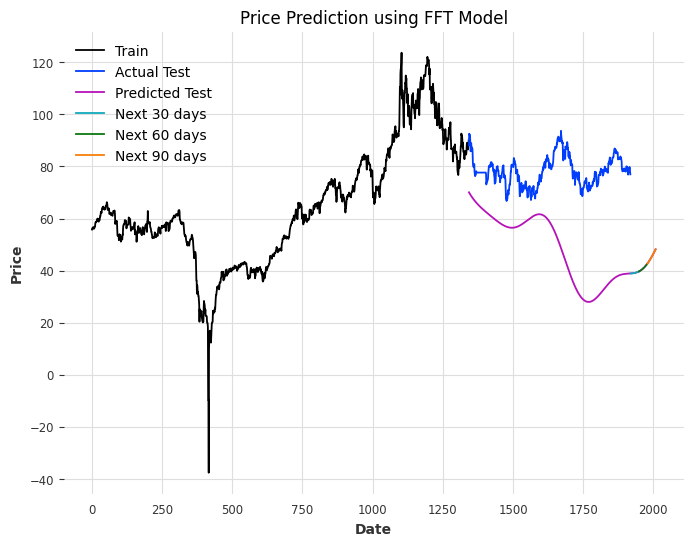

In [63]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

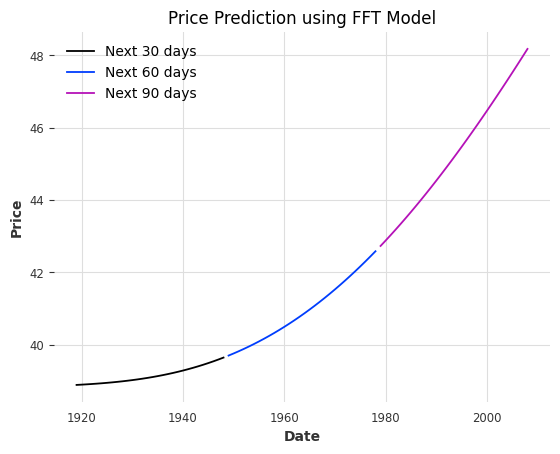

In [64]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

## 8:2

In [65]:
train_size = int(len(price_scaled) * 0.8)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [66]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [67]:
forecast = model.predict(len(series_test))

In [68]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.1611551029427775
MAE: 0.14284098105730067
MAPE: 19.51140078172624%


In [69]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 474, component: 1, sample: 1)> Size: 4kB
array([[[0.64065196]],

       [[0.64021696]],

       [[0.63979219]],

       [[0.63937741]],

       [[0.63897239]],

       [[0.63857689]],

       [[0.63819065]],

       [[0.63781342]],

       [[0.63744495]],

       [[0.63708495]],

...

       [[0.42548919]],

       [[0.42685399]],

       [[0.42823042]],

       [[0.42961764]],

       [[0.43101482]],

       [[0.4324211 ]],

       [[0.43383565]],

       [[0.43525763]],

       [[0.4366862 ]],

       [[0.43812052]]])
Coordinates:
  * time       (time) int64 4kB 1535 1536 1537 1538 1539 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


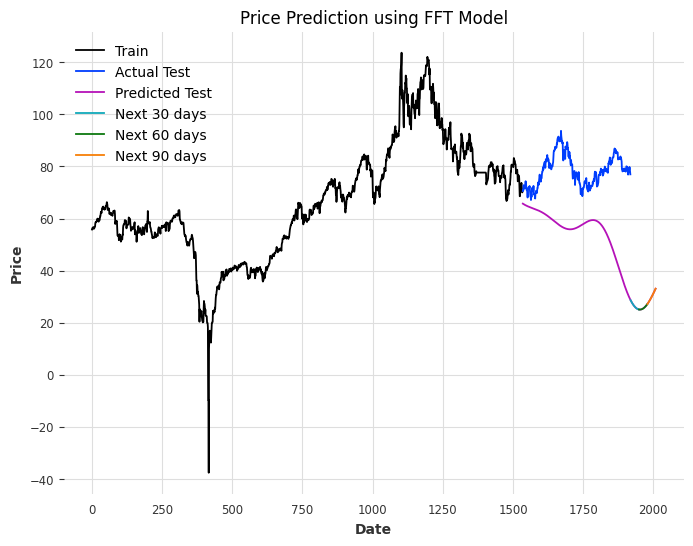

In [70]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

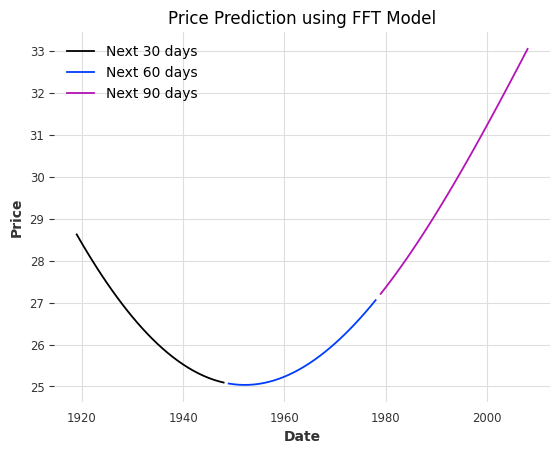

In [71]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

### 9:1

In [72]:
train_size = int(len(price_scaled) * 0.9)
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]
series_train = TimeSeries.from_dataframe(pd.DataFrame(train_data, columns=['Price']))
series_test = TimeSeries.from_dataframe(pd.DataFrame(test_data, columns=['Price']))

In [73]:
model = FFT()
model.fit(series_train)

FFT(nr_freqs_to_keep=10, required_matches=None, trend=None, trend_poly_degree=3)

In [74]:
forecast = model.predict(len(series_test))

In [75]:
rmse = np.sqrt(np.mean((series_test.values() - forecast.values()) ** 2))
mae = np.mean(np.abs(series_test.values() - forecast.values()))
mape = np.mean(np.abs((series_test.values() - forecast.values()) / series_test.values())) * 100

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')

RMSE: 0.1363916004588039
MAE: 0.11887947552698384
MAPE: 16.33581569257608%


In [76]:
forecast_90 = model.predict(len(series_test) + 90)
print(forecast_90)

<TimeSeries (DataArray) (time: 282, component: 1, sample: 1)> Size: 2kB
array([[[0.69344184]],

       [[0.69232796]],

       [[0.69120029]],

       [[0.6900591 ]],

       [[0.68890465]],

       [[0.68773719]],

       [[0.686557  ]],

       [[0.68536436]],

       [[0.68415954]],

       [[0.68294284]],

...

       [[0.60138514]],

       [[0.60105989]],

       [[0.60071373]],

       [[0.60034663]],

       [[0.5999586 ]],

       [[0.59954963]],

       [[0.59911974]],

       [[0.59866895]],

       [[0.59819729]],

       [[0.5977048 ]]])
Coordinates:
  * time       (time) int64 2kB 1727 1728 1729 1730 1731 ... 2005 2006 2007 2008
  * component  (component) object 8B 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


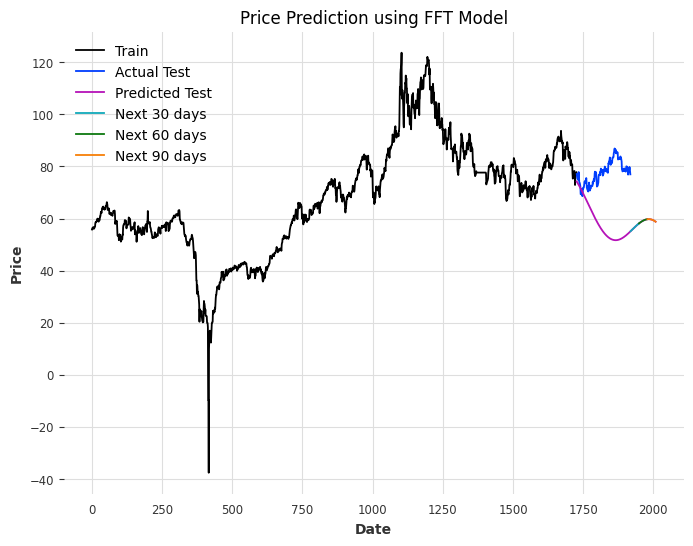

In [77]:
train_data_df = pd.DataFrame(scaler.inverse_transform(train_data), columns=['Price'])
test_data_df = pd.DataFrame(scaler.inverse_transform(test_data), columns=['Price'])
test_predict_df = pd.DataFrame(scaler.inverse_transform(forecast_90.values()), columns=['Price'])

train_length = len(train_data_df)
test_length = len(test_data_df)
test_predict_length = len(test_predict_df)

test_data_df.index = range(train_length, train_length + test_length)
test_predict_df.index = range(train_length, train_length + test_predict_length)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()

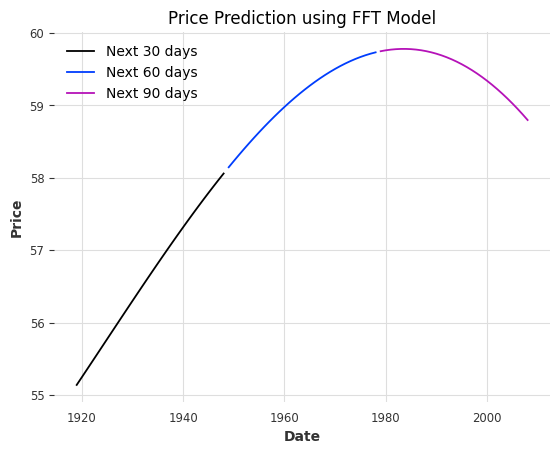

In [78]:
plt.plot(test_predict_df[len(series_test):len(series_test)+30], label='Next 30 days')
plt.plot(test_predict_df[len(series_test)+30:len(series_test)+60], label='Next 60 days')
plt.plot(test_predict_df[len(series_test)+60:len(series_test)+90], label='Next 90 days')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Prediction using FFT Model')
plt.show()